In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
!unzip /content/drive/MyDrive/data.zip -d data

In [ ]:
!pip install wandb -qU

In [ ]:
import copy
import wandb

import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

#using numpy
import numpy as np

#for data load or save
import pandas as pd

#visualize some datasets
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
wandb.login()

In [ ]:
train = pd.read_csv('/content/data/data_for_achive/train/answers.csv')
test = pd.read_csv('/content/data/data_for_achive/test/image_names.csv')

In [ ]:
print(train.shape)
print(test.shape)

(10000, 2)
(5000, 1)


In [ ]:
train

,Unnamed: 0,count
0,train_0000.png,2
1,train_0001.png,3
2,train_0002.png,4
3,train_0003.png,1
4,train_0004.png,4
...,...,...
9995,train_9995.png,3
9996,train_9996.png,2
9997,train_9997.png,2
9998,train_9998.png,3


In [ ]:
np.unique(train['count'],return_counts=True)

(array([1, 2, 3, 4, 5]), array([1461, 2114, 2870, 2097, 1458]))

In [ ]:
import os
train_dir = '/content/data/data_for_achive/train/pictures'
test_dir = '/content/data/data_for_achive/test/pictures'

In [ ]:
import glob

train_list = glob.glob(os.path.join(train_dir,'*.png'))
test_list = glob.glob(os.path.join(test_dir, '*.png'))


In [ ]:
test_list = [f"{test_dir}/test_{str(i).rjust(4, '0')}.png" for i in range(5000)]

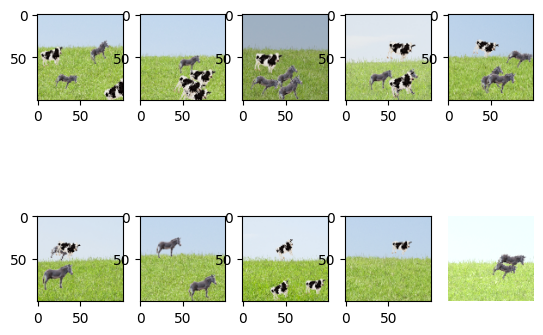

In [ ]:
from PIL import Image
random_idx = np.random.randint(1,9999,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(train_list[idx])
    plt.imshow(img)
    i+=1

plt.axis('off')
plt.show()

In [ ]:

#data Augumentation
transforms =  transforms.Compose([
        transforms.Resize((100, 100))
        transforms.RandomHorizontalFlip(0.2)
        transforms.RandomRotation(degrees=30)
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


https://datagy.io/pytorch-transforms/

In [ ]:
train['count'] = train['count'] -1
train

,Unnamed: 0,count
0,train_0000.png,1
1,train_0001.png,2
2,train_0002.png,3
3,train_0003.png,0
4,train_0004.png,3
...,...,...
9995,train_9995.png,2
9996,train_9996.png,1
9997,train_9997.png,1
9998,train_9998.png,2


In [ ]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform


    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    #load an one of images
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path).convert('RGB')
        img_transformed = self.transform(img)
        if len(train[train['Unnamed: 0'] == img_path.split('/')[-1]]['count'])>0:
          label = int(train[train['Unnamed: 0'] == img_path.split('/')[-1]]['count'])
        else:
          label = 0
        return img_transformed,label

In [ ]:
from sklearn.model_selection import train_test_split
train_list, val_list = train_test_split(train_list, test_size=0.05)

In [ ]:
train_data = dataset(train_list, transform=transforms)
test_data = dataset(test_list, transform=transforms)
val_data = dataset(val_list, transform=transforms)

In [ ]:
batch_size = 64

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

In [ ]:
print(len(train_data), len(train_loader))

9500 149


In [ ]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(6400,100)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(100,5)
        self.relu = nn.ReLU()


    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out



In [ ]:
lr = 0.001 # learning_rate
epochs = 100 # How much to train a model

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
model = Cnn().to(device)
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=6400, out_features=100, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=100, out_features=5, bias=True)
  

In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 98, 98]             448
       BatchNorm2d-2           [-1, 16, 98, 98]              32
              ReLU-3           [-1, 16, 98, 98]               0
         MaxPool2d-4           [-1, 16, 49, 49]               0
            Conv2d-5           [-1, 32, 47, 47]           4,640
       BatchNorm2d-6           [-1, 32, 47, 47]              64
              ReLU-7           [-1, 32, 47, 47]               0
         MaxPool2d-8           [-1, 32, 23, 23]               0
            Conv2d-9           [-1, 64, 21, 21]          18,496
      BatchNorm2d-10           [-1, 64, 21, 21]             128
             ReLU-11           [-1, 64, 21, 21]               0
        MaxPool2d-12           [-1, 64, 10, 10]               0
           Linear-13                  [-1, 100]         640,100
             ReLU-14                  [

In [ ]:
lr = 0.01
optimizer = optim.AdamW(params = model.parameters(),lr=lr, weight_decay=0.1)
criterion = nn.CrossEntropyLoss()

In [ ]:
epochs = 40

accuracy_history = []
val_accuracy_history = []
loss_history = []
val_loss_history = []

best_val_loss = float('inf')
best_model = None

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

wandb.init(
    project="pytorch-intro",
    config={
        "epochs": epochs,
        "batch_size": batch_size,
        "lr": lr
        })

# Copy your config
config = wandb.config


for epoch in range(config.epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
    accuracy_history.append(epoch_accuracy.detach().cpu().numpy())
    loss_history.append(epoch_loss.detach().cpu().numpy())

    metrics = {"train/train_loss": epoch_loss,
                "train/accuracy": epoch_accuracy}


    with torch.no_grad():

        epoch_val_accuracy=0
        epoch_val_loss =0

        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output,label)


            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(val_loader)
            epoch_val_loss += val_loss/ len(val_loader)
        print(f'Epoch [{epoch+1}/{epochs}], train Loss: {epoch_loss:.4f}, train accuracy: {epoch_accuracy:.4f},  val Loss: {epoch_val_loss:.4f}, val accuracy: {epoch_val_accuracy:.4f}')
        val_accuracy_history.append(epoch_val_accuracy.detach().cpu().numpy())
        val_loss_history.append(epoch_val_loss.detach().cpu().numpy())

        val_metrics = {"val/val_loss": epoch_val_loss,
                       "val/val_accuracy": epoch_val_accuracy}
        wandb.log({**metrics, **val_metrics})

        if epoch_val_loss < best_val_loss:

          best_val_loss = epoch_val_loss
          best_model = copy.deepcopy(model)
          torch.save(best_model.state_dict(), 'best_model.pt')
          print('best model saved!')


plt.plot(accuracy_history, label='accuracy')
plt.plot(val_accuracy_history, label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


Epoch : 1, train accuracy : 0.4305339455604553, train loss : 1.9193898439407349
Epoch : 1, val_accuracy : 0.5141226053237915, val_loss : 1.02560555934906
Epoch : 2, train accuracy : 0.6501526832580566, train loss : 0.76788729429245
Epoch : 2, val_accuracy : 0.5609976053237915, val_loss : 0.8685749173164368
Epoch : 3, train accuracy : 0.706720232963562, train loss : 0.6661568284034729
Epoch : 3, val_accuracy : 0.743239164352417, val_loss : 0.5972468256950378
Epoch : 4, train accuracy : 0.7485167384147644, train loss : 0.5806750655174255
Epoch : 4, val_accuracy : 0.8454026579856873, val_loss : 0.448783814907074
Epoch : 5, train accuracy : 0.7448318600654602, train loss : 0.594444751739502
Epoch : 5, val_accuracy : 0.8323317170143127, val_loss : 0.44249406456947327
Epoch : 6, train accuracy : 0.7787631750106812, train loss : 0.5225033760070801
Epoch : 6, val_accuracy : 0.5658053159713745, val_loss : 0.8851051926612854
Epoch : 7, train accuracy : 0.7645015120506287, train loss : 0.54828697

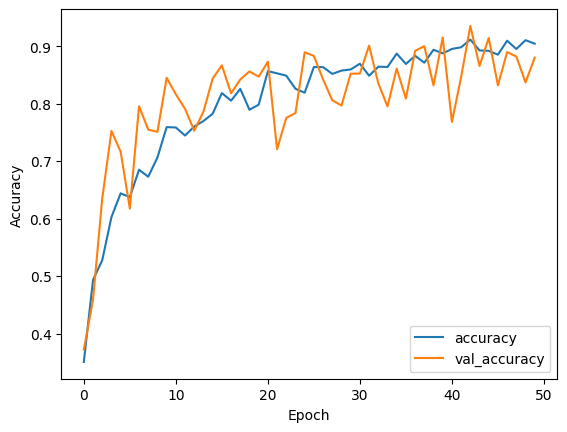

In [ ]:
plt.plot(accuracy, label='accuracy')
plt.plot(val_accuracy, label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.eval()
ans = []
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = np.argmax(F.softmax(preds, dim=1).tolist(), axis = 1)
        for i in preds_list:
          ans.append(i+1)

In [ ]:
submission = pd.read_csv('/content/data/data_for_achive/test/sample_submission.csv')
submission['count'] =  ans
submission.to_csv("submission_93.csv", index=False)

In [ ]:
results = pd.Series(ans, name="Label")

submission.to_csv("submission.csv", index=False)

In [ ]:
from IPython.display import FileLink
FileLink('submission.csv')

/kaggle/working/submission.csv

# Pre-train model

In [ ]:
import pickle
import numpy as np
from skimage import io
import pandas as pd

from tqdm import tqdm,tqdm_notebook
from PIL import Image
from pathlib import Path
import math

from torchvision import transforms
import torch
import torchvision
from torch.optim import lr_scheduler


In [ ]:
model = torchvision.models.resnet18(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 106MB/s]


In [ ]:
n_classes = 5
model.fc = nn.Linear(512, n_classes)

In [ ]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
blocks_to_freeze = 5
for i, layer in enumerate(model.children()):
  if i < blocks_to_freeze:
    for param in layer.parameters():
      param.requires_grad = False

In [ ]:
criterion = nn.L1Loss()
optimmizer = torch.optim.AdamW(model.parameters(), lr = 0.001, weight_decay=0.1)
scheduler = lr_scheduler.StepLR(optimmizer, step_size = 3, gamma = 0.5)

In [ ]:
lr = 0.01
optimizer = optim.AdamW(params = model.parameters(),lr=lr, weight_decay=0.1)
criterion = nn.CrossEntropyLoss()

Epoch [1/40], Train Loss: 0.4698, train accuracy: 0.8123
Epoch [1/40], Val Loss: 0.4413, val accuracy: 0.8039
best model saved!
Epoch [2/40], Train Loss: 0.4196, train accuracy: 0.8342
Epoch [2/40], Val Loss: 0.4045, val accuracy: 0.8301
best model saved!
Epoch [3/40], Train Loss: 0.3457, train accuracy: 0.8672
Epoch [3/40], Val Loss: 0.3606, val accuracy: 0.8592
best model saved!
Epoch [4/40], Train Loss: 0.3047, train accuracy: 0.8848
Epoch [4/40], Val Loss: 0.2335, val accuracy: 0.9118
best model saved!
Epoch [5/40], Train Loss: 0.2851, train accuracy: 0.8922
Epoch [5/40], Val Loss: 0.2373, val accuracy: 0.9216
Epoch [6/40], Train Loss: 0.2797, train accuracy: 0.8950
Epoch [6/40], Val Loss: 0.3574, val accuracy: 0.8741
Epoch [7/40], Train Loss: 0.2353, train accuracy: 0.9145
Epoch [7/40], Val Loss: 0.3135, val accuracy: 0.8825
Epoch [8/40], Train Loss: 0.2945, train accuracy: 0.8893
Epoch [8/40], Val Loss: 0.3220, val accuracy: 0.8685
Epoch [9/40], Train Loss: 0.2349, train accuracy

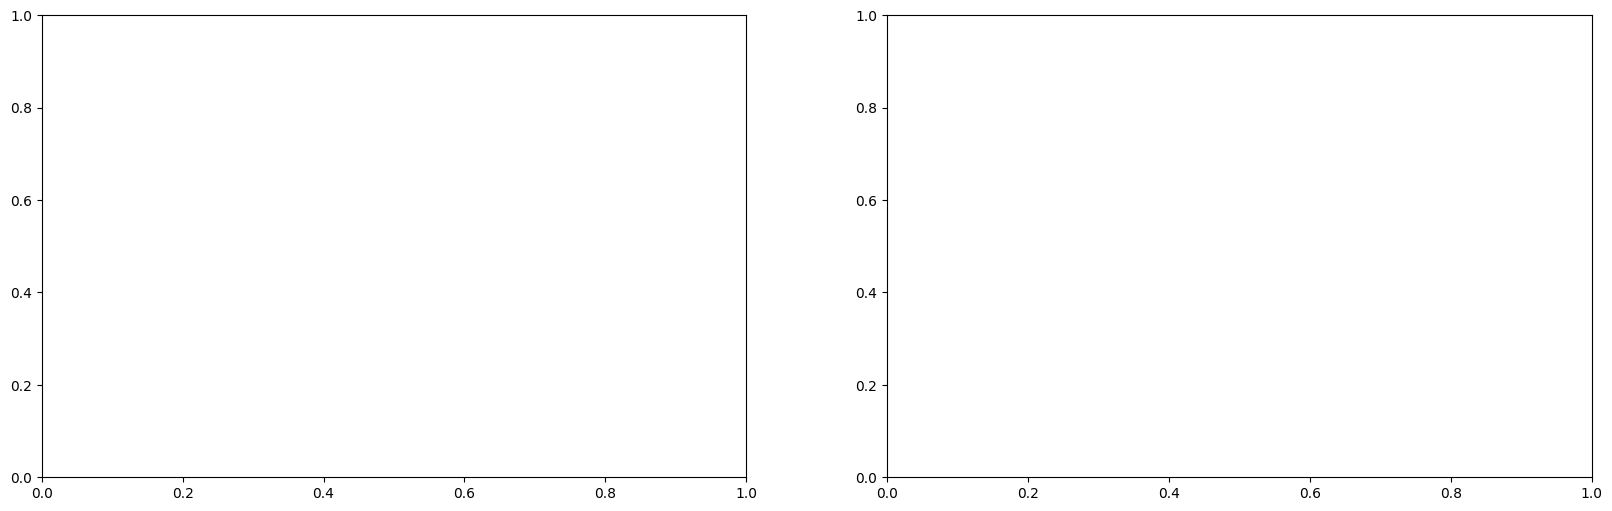

In [ ]:
epochs = 40

accuracy_history = []
val_accuracy_history = []
loss_history = []
val_loss_history = []

best_val_loss = float('inf')
best_model = None

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

wandb.init(
    project="pytorch-intro",
    config={
        "epochs": epochs,
        "batch_size": batch_size,
        "lr": lr
        })

# Copy your config
config = wandb.config


for epoch in range(config.epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
    accuracy_history.append(epoch_accuracy.detach().cpu().numpy())
    loss_history.append(epoch_loss.detach().cpu().numpy())

    metrics = {"train/train_loss": epoch_loss,
                "train/accuracy": epoch_accuracy}


    with torch.no_grad():

        epoch_val_accuracy=0
        epoch_val_loss =0

        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output,label)


            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(val_loader)
            epoch_val_loss += val_loss/ len(val_loader)
        print(f'Epoch [{epoch+1}/{epochs}], train Loss: {epoch_loss:.4f}, train accuracy: {epoch_accuracy:.4f},  val Loss: {epoch_val_loss:.4f}, val accuracy: {epoch_val_accuracy:.4f}')
        val_accuracy_history.append(epoch_val_accuracy.detach().cpu().numpy())
        val_loss_history.append(epoch_val_loss.detach().cpu().numpy())

        val_metrics = {"val/val_loss": epoch_val_loss,
                       "val/val_accuracy": epoch_val_accuracy}
        wandb.log({**metrics, **val_metrics})

        if epoch_val_loss < best_val_loss:

          best_val_loss = epoch_val_loss
          best_model = copy.deepcopy(model)
          torch.save(best_model.state_dict(), 'best_model.pt')
          print('best model saved!')


plt.plot(accuracy_history, label='accuracy')
plt.plot(val_accuracy_history, label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
torch.save(best_model.state_dict(), 'best_model.pt')

## NN for detecting